In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p
from scipy.io import arff

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/home/iai/anaconda3/envs/bongjun_torch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#!unzip -q ./dataset/ECG5000.zip

In [3]:
with open('./dataset/ECG5000_TRAIN.arff') as f:
  train = arff.loadarff(f)

with open('./dataset/ECG5000_TEST.arff') as f:
  test = arff.loadarff(f)

In [4]:
train_df = pd.DataFrame(train[0])
test_df = pd.DataFrame(test[0])

In [5]:
df = pd.concat([train_df,test_df], axis = 0)
df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,b'4'
4496,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,b'2'
4497,-1.351779,-2.209006,-2.520225,-3.061475,-3.065141,-3.030739,-2.622720,-2.044092,-1.295874,-0.733839,...,-1.512234,-2.076075,-2.586042,-3.322799,-3.627311,-3.437038,-2.260023,-1.577823,-0.684531,b'2'
4498,-1.124432,-1.905039,-2.192707,-2.904320,-2.900722,-2.761252,-2.569705,-2.043893,-1.490538,-0.938473,...,-2.821782,-3.268355,-3.634981,-3.168765,-2.245878,-1.262260,-0.443307,-0.559769,0.108568,b'2'


In [6]:
CLASS_NORMAL = 1
class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

In [7]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

In [8]:
df.target=df.target.astype(int)

In [9]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

In [10]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

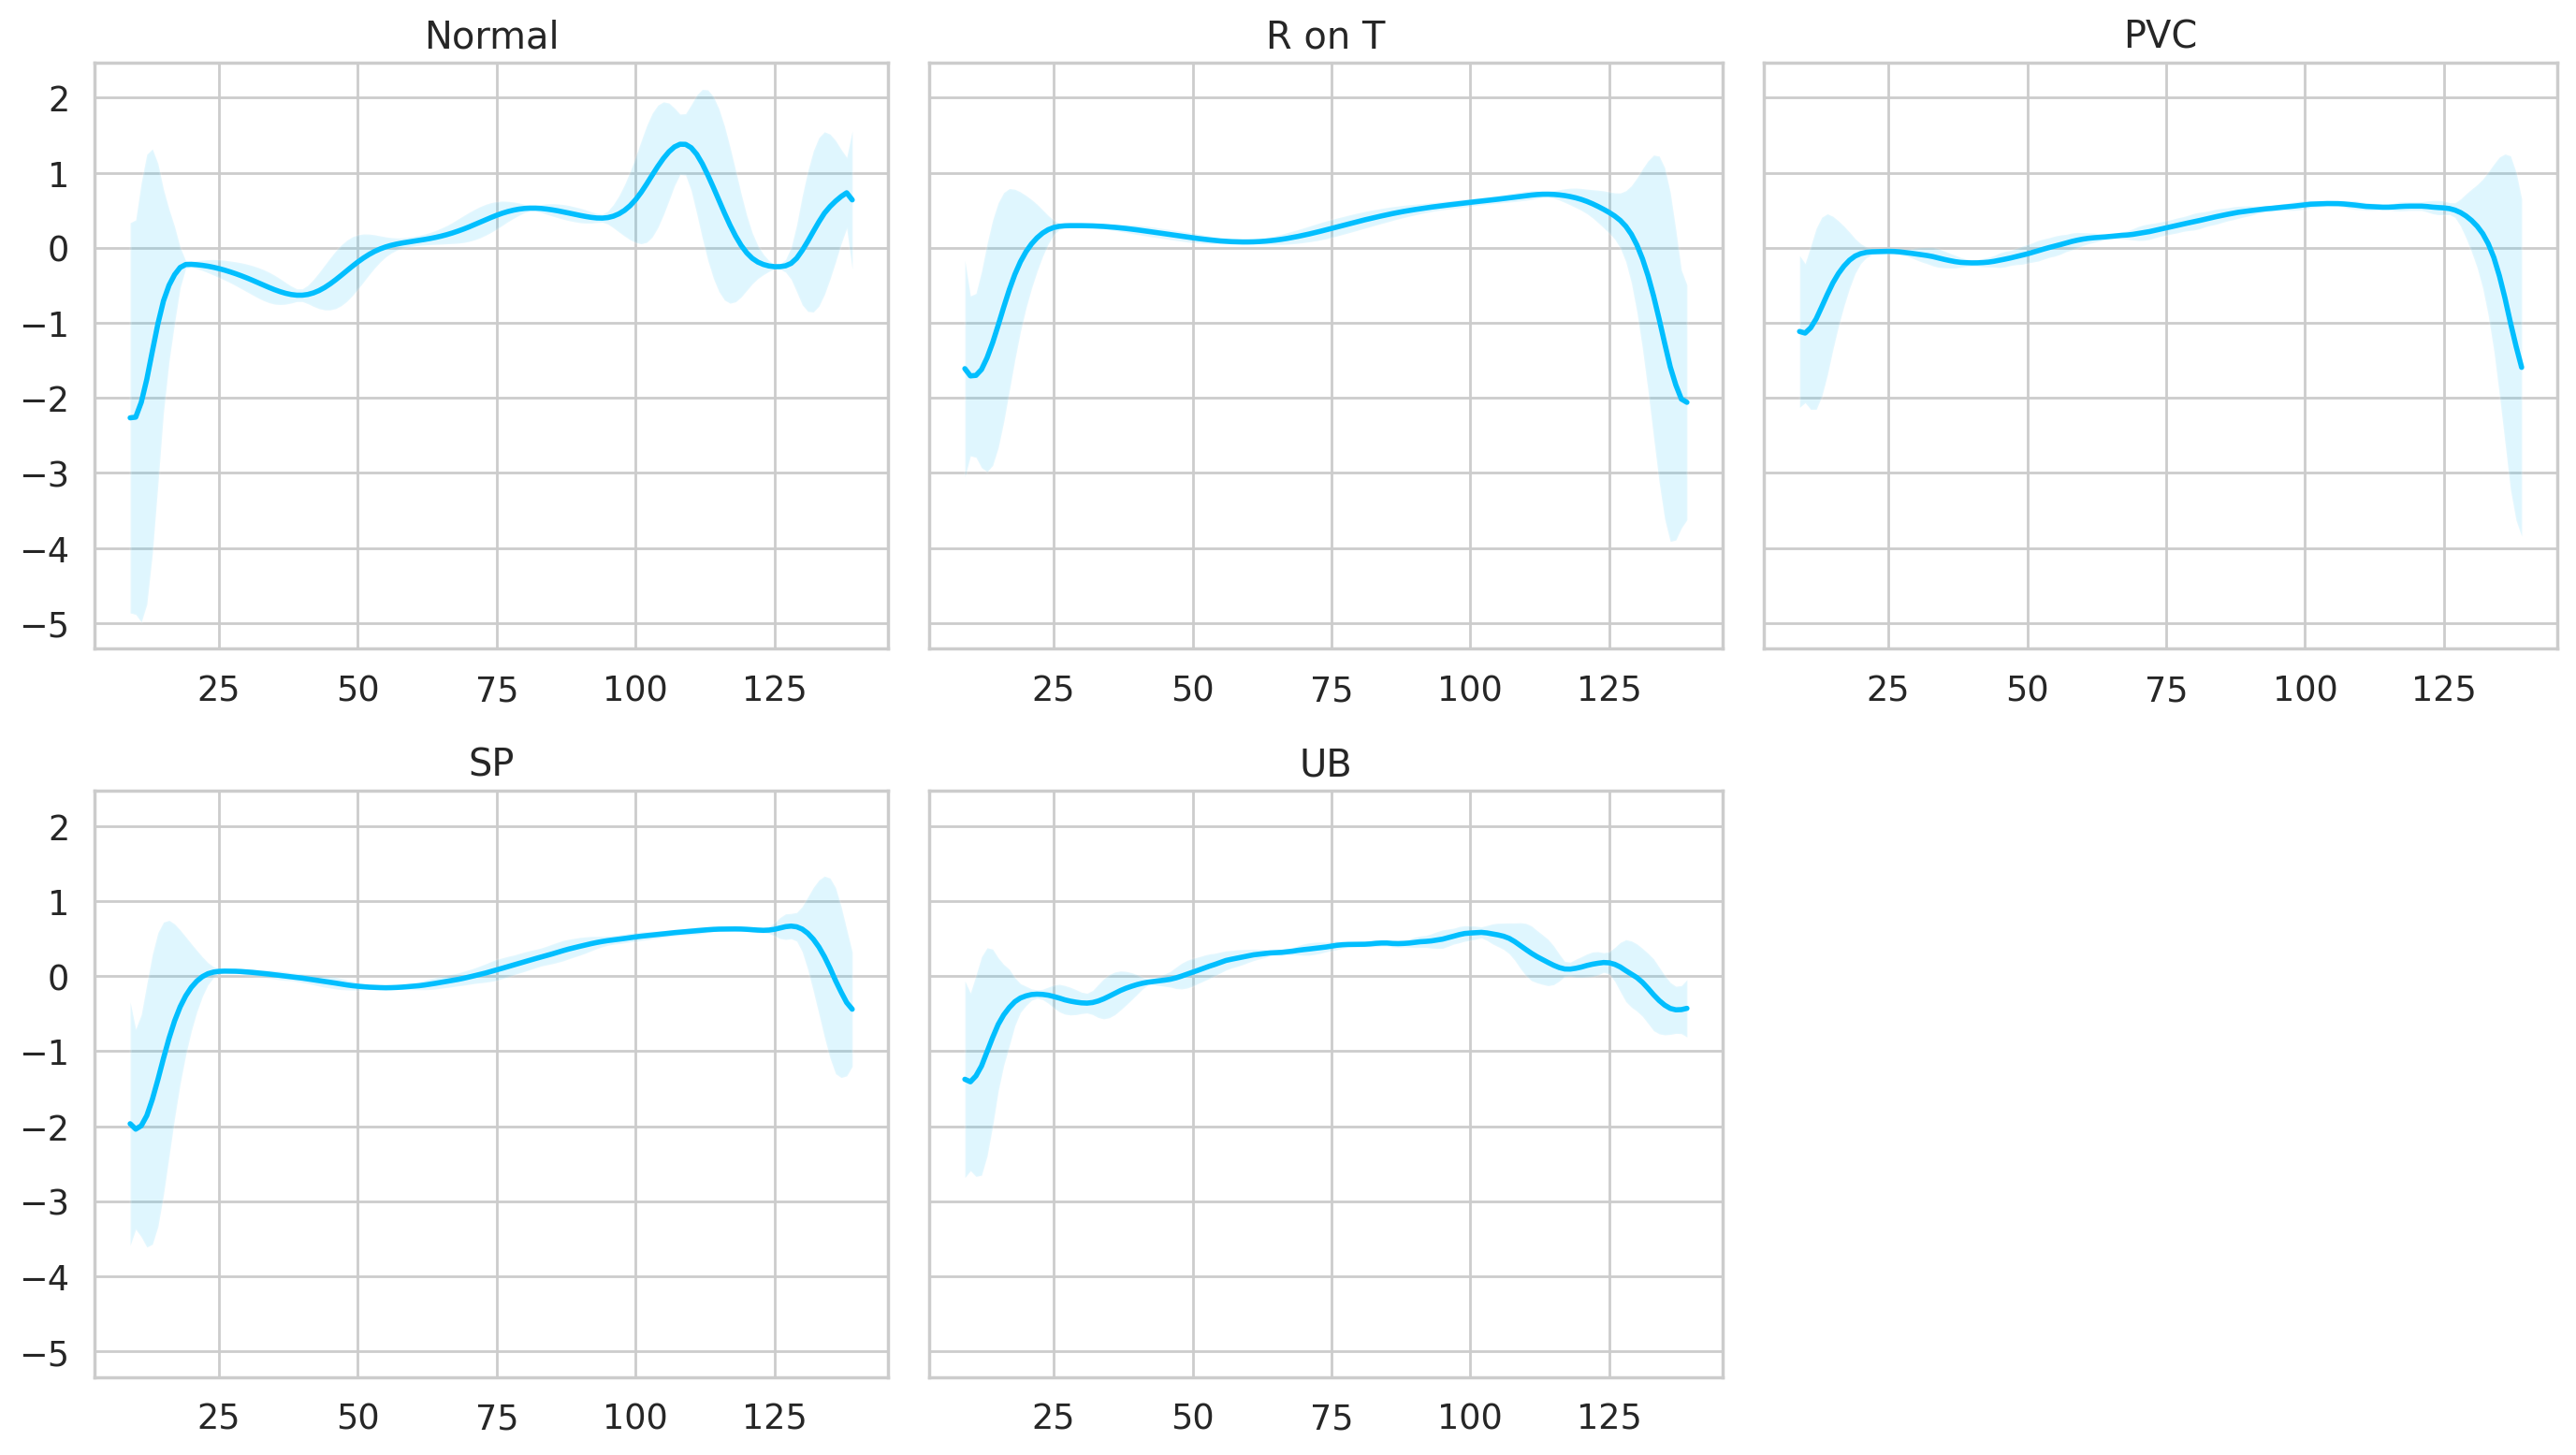

In [11]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

## Data Preprocessing

In [12]:
normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

In [13]:
anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [14]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

In [15]:
def create_dataset(df):

    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.Tensor(s).unsqueeze(1).float() for s in sequences] #(140,1)
    n_seq, seq_len, n_features = torch.stack(dataset).shape

    return dataset, seq_len, n_features

In [16]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

## LSTM Autoencoder

In [38]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2*embedding_dim

        self.rnn1 = nn.LSTM(
            input_size = n_features,
            hidden_size = self.hidden_dim,
            num_layers = 1,
            batch_first = True
        )

        self.rnn2 = nn.LSTM(
            input_size = self.hidden_dim,
            hidden_size = embedding_dim,
            num_layers = 1,
            batch_first = True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        
        x, (_,_) = self.rnn1(x)
        x, (hidden_n,_ ) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))



In [44]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder,self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2*input_dim, n_features

        self.rnn1 = nn.LSTM(
            input_size = input_dim,
            hidden_size = input_dim,
            num_layers = 1,
            batch_first = True
        )

        self.rnn2 = nn.LSTM(
            input_size = input_dim,
            hidden_size = self.hidden_dim,
            num_layers = 1,
            batch_first = True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n,cell_n) = self.rnn1(x)
        x, (hidden_n,cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

In [45]:
class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [46]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [47]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    #optimizer 및 criterion 선언
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.L1Loss(reduction='sum').to(device)
    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss =10000.0

    for epoch in range(1, n_epochs + 1):
        #model 학습시에는 model.train()
        model = model.train()

        train_losses = []

        for seq_true in train_dataset:
            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        #model inference 시에는 항상 model.eval() => dropout, batchnorm 같은 layer는 학습,테스트시 동작이 다르기 때문에 필요!
        model = model.eval()

        #gradient 계산을 안시키게 해서, 메모리 최적화 가능
        with torch.no_grad():
            for seq_true in val_dataset:
                
                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())


        print(f'Epoch {epoch}: train loss {train_loss}, val loss {val_loss}')

    model.load_state_dict(best_model_wts)
    return model.eval(), history

In [48]:
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=150
)
#약 1시간 학습

Epoch 1: train loss 61.243781471483075, val loss 53.01797856405734
Epoch 2: train loss 49.663474002609036, val loss 48.74435116894823
Epoch 3: train loss 40.216549049217534, val loss 31.797065884586893
Epoch 4: train loss 30.984627373129165, val loss 28.303349081566715
Epoch 5: train loss 28.0702110461197, val loss 26.03059655733076
Epoch 6: train loss 27.22314310708098, val loss 26.560270553562827
Epoch 7: train loss 25.819043885215258, val loss 23.021415944799223
Epoch 8: train loss 24.92122095969837, val loss 24.00713462634298
Epoch 9: train loss 35.38309599420131, val loss 37.12827817246369
Epoch 10: train loss 36.61406846567298, val loss 28.897432857812873
Epoch 11: train loss 32.49805152305717, val loss 29.112803446148035
Epoch 12: train loss 29.798739528233174, val loss 27.75771223074747
Epoch 13: train loss 27.37691768683142, val loss 25.627080953161872
Epoch 14: train loss 26.03534221303218, val loss 24.235801244351645
Epoch 15: train loss 25.222901524963135, val loss 23.04309

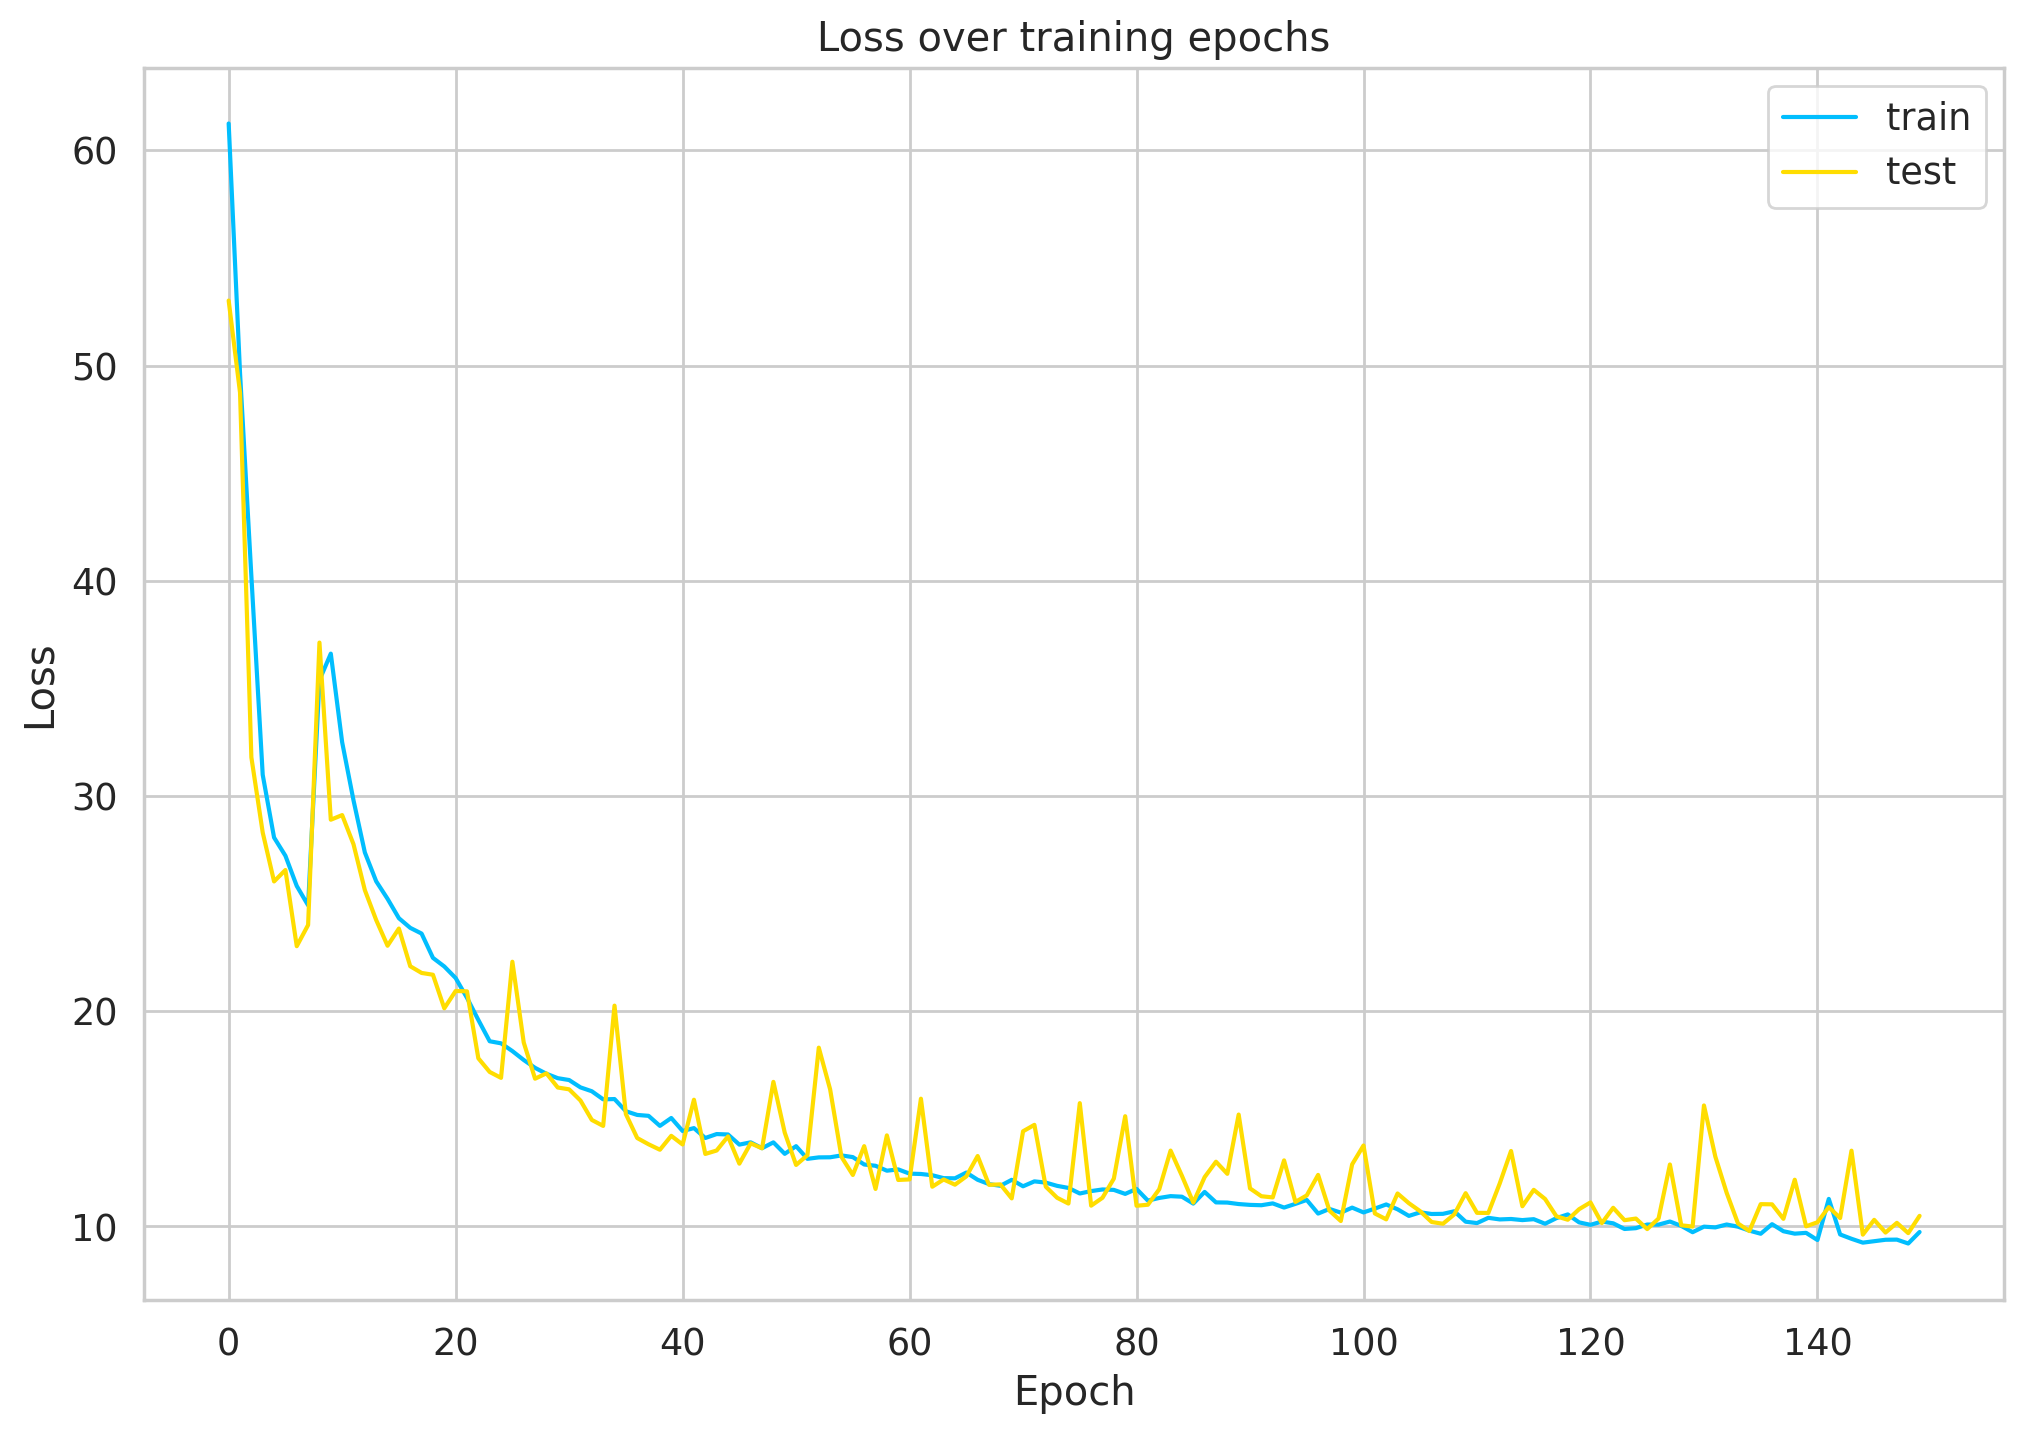

In [49]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'])
plt.title('Loss over training epochs')
plt.show()

In [50]:
MODEL_PATH = './model_params/TS_AD_LSTMAE_model.pth'

torch.save(model, MODEL_PATH)

In [ ]:
#불러오기
#model = torch.load(MODEL_PATH)
#model = model.to(device)

## Choosing a Threshold

In [51]:
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    
    with torch.no_grad():
        model = model.eval()

        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred,seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    
    return predictions, losses

/tmp/ipykernel_249364/3614772348.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True)


<AxesSubplot: ylabel='Density'>

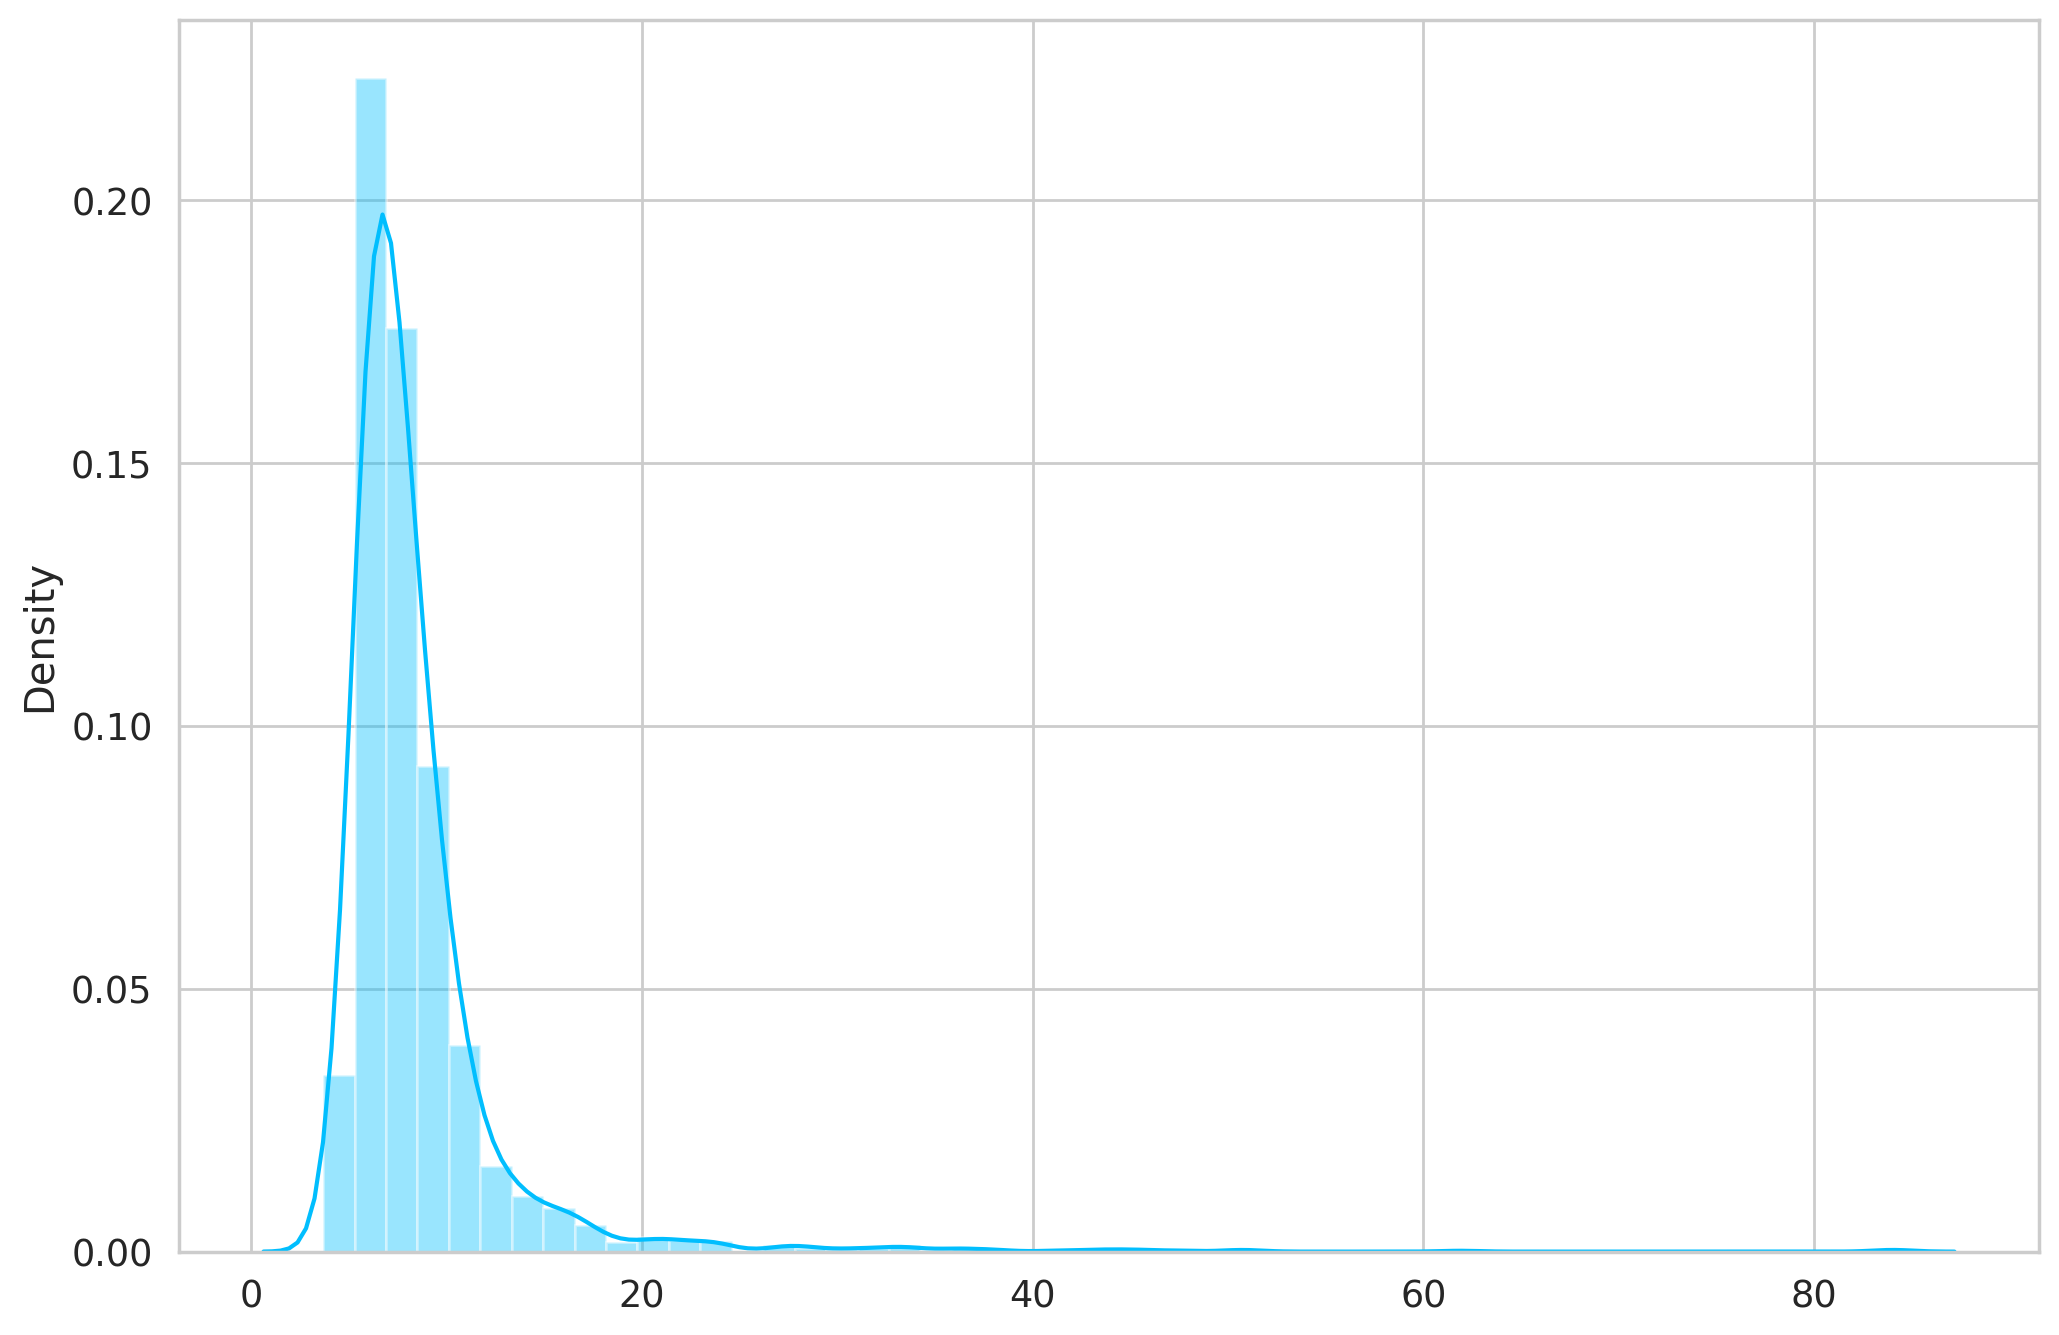

In [52]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True)

In [53]:
THRESHOLD = 26

/tmp/ipykernel_249364/2126617902.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True)


<AxesSubplot: ylabel='Density'>

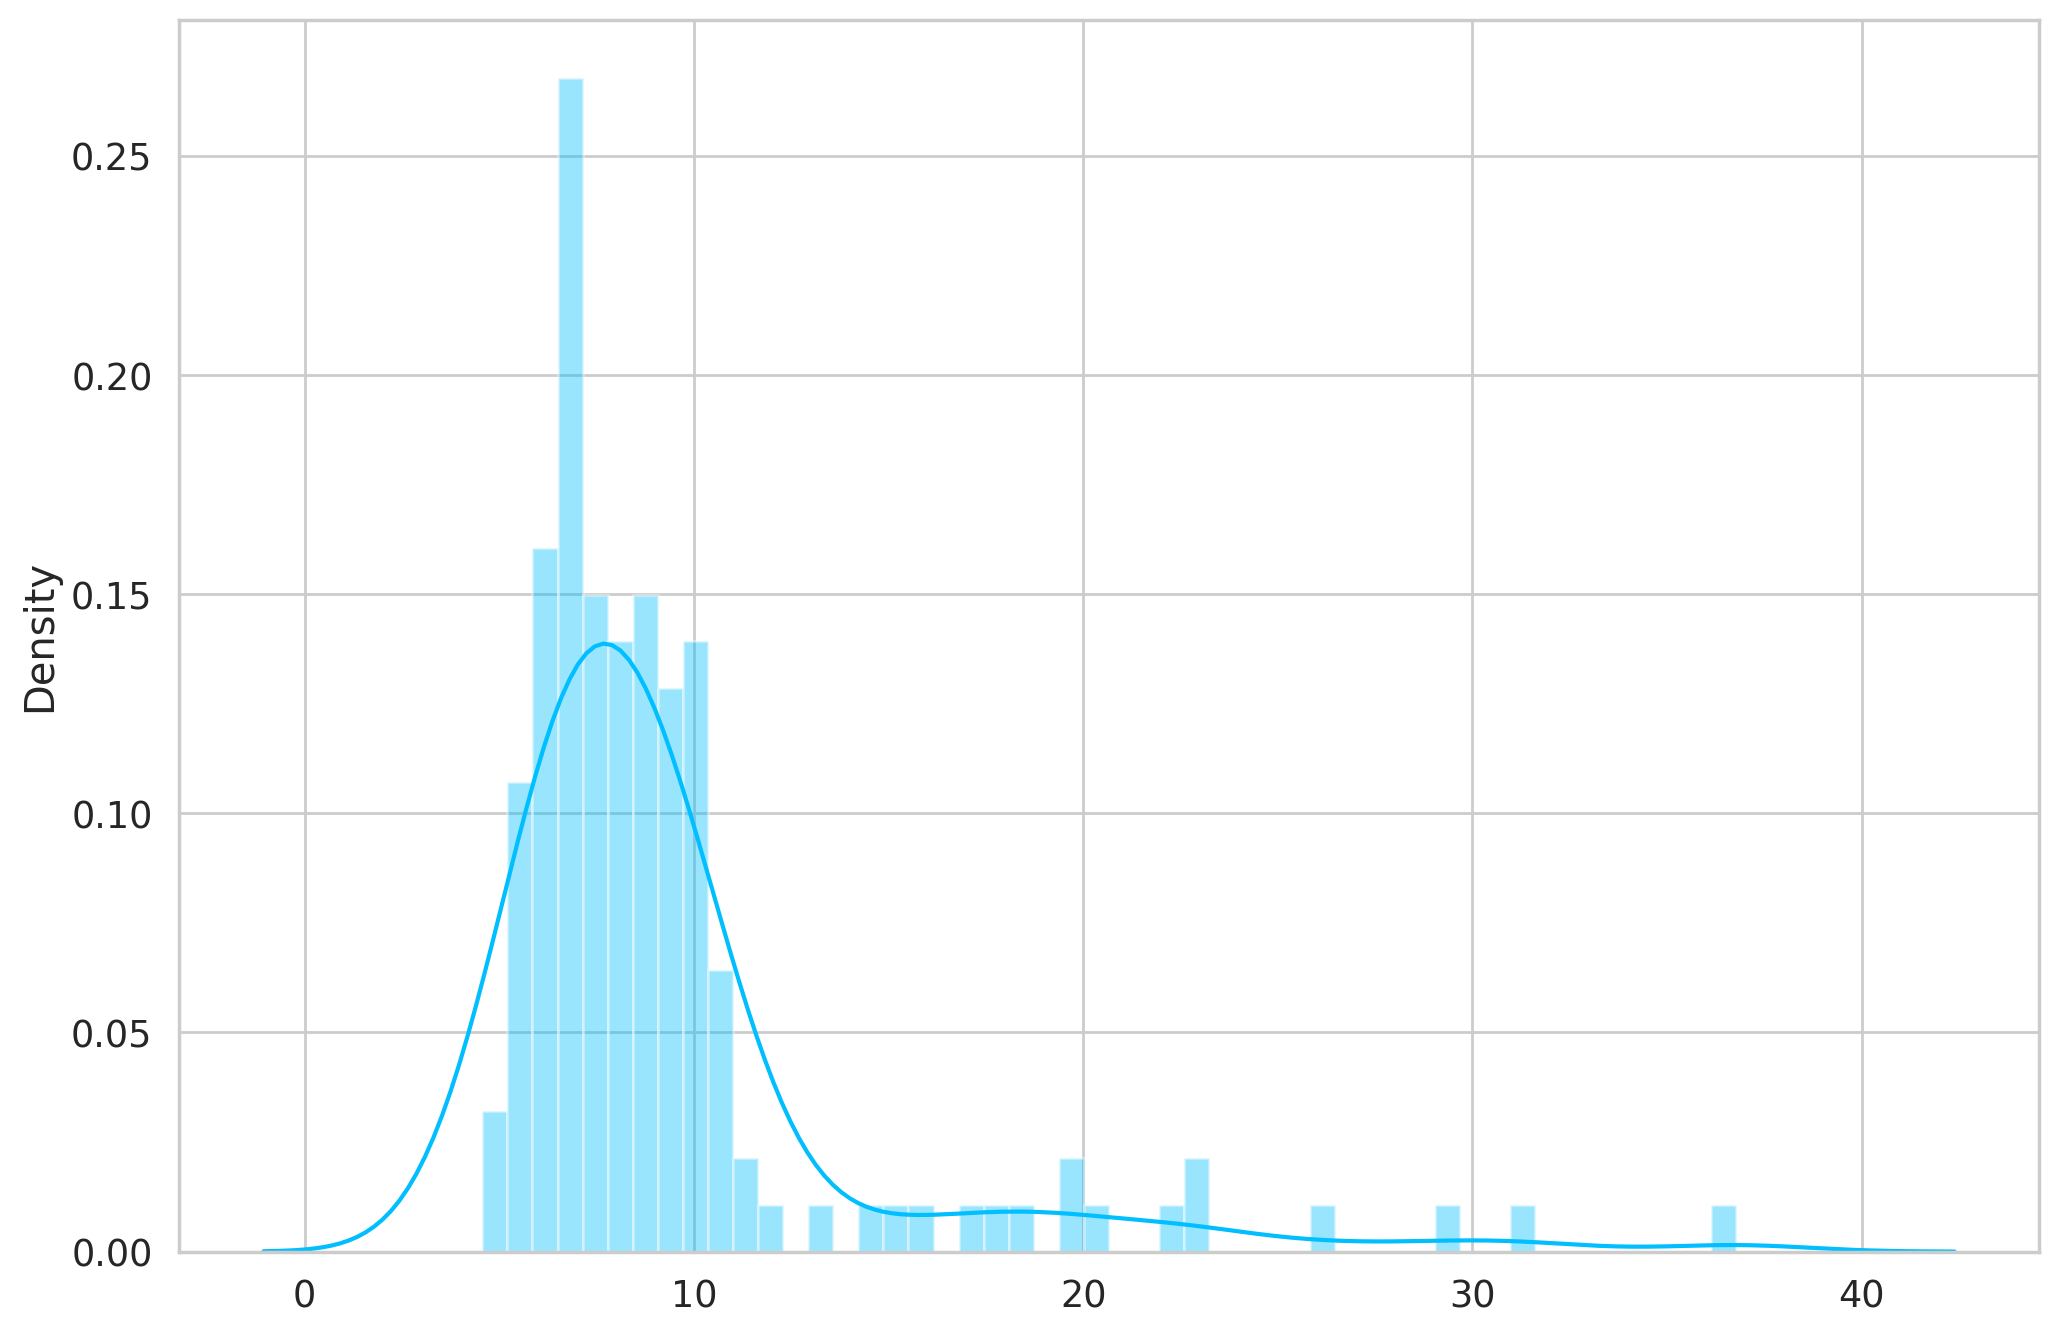

In [54]:
predictions, pred_losses = predict(model, test_normal_dataset)

sns.distplot(pred_losses, bins=50, kde=True)

In [56]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal prediction: {correct}/{len(test_normal_dataset)}')

Correct normal prediction: 142/145


## Anomalies

In [59]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

/tmp/ipykernel_249364/1361860855.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred_losses, bins=50, kde=True)


<AxesSubplot: ylabel='Density'>

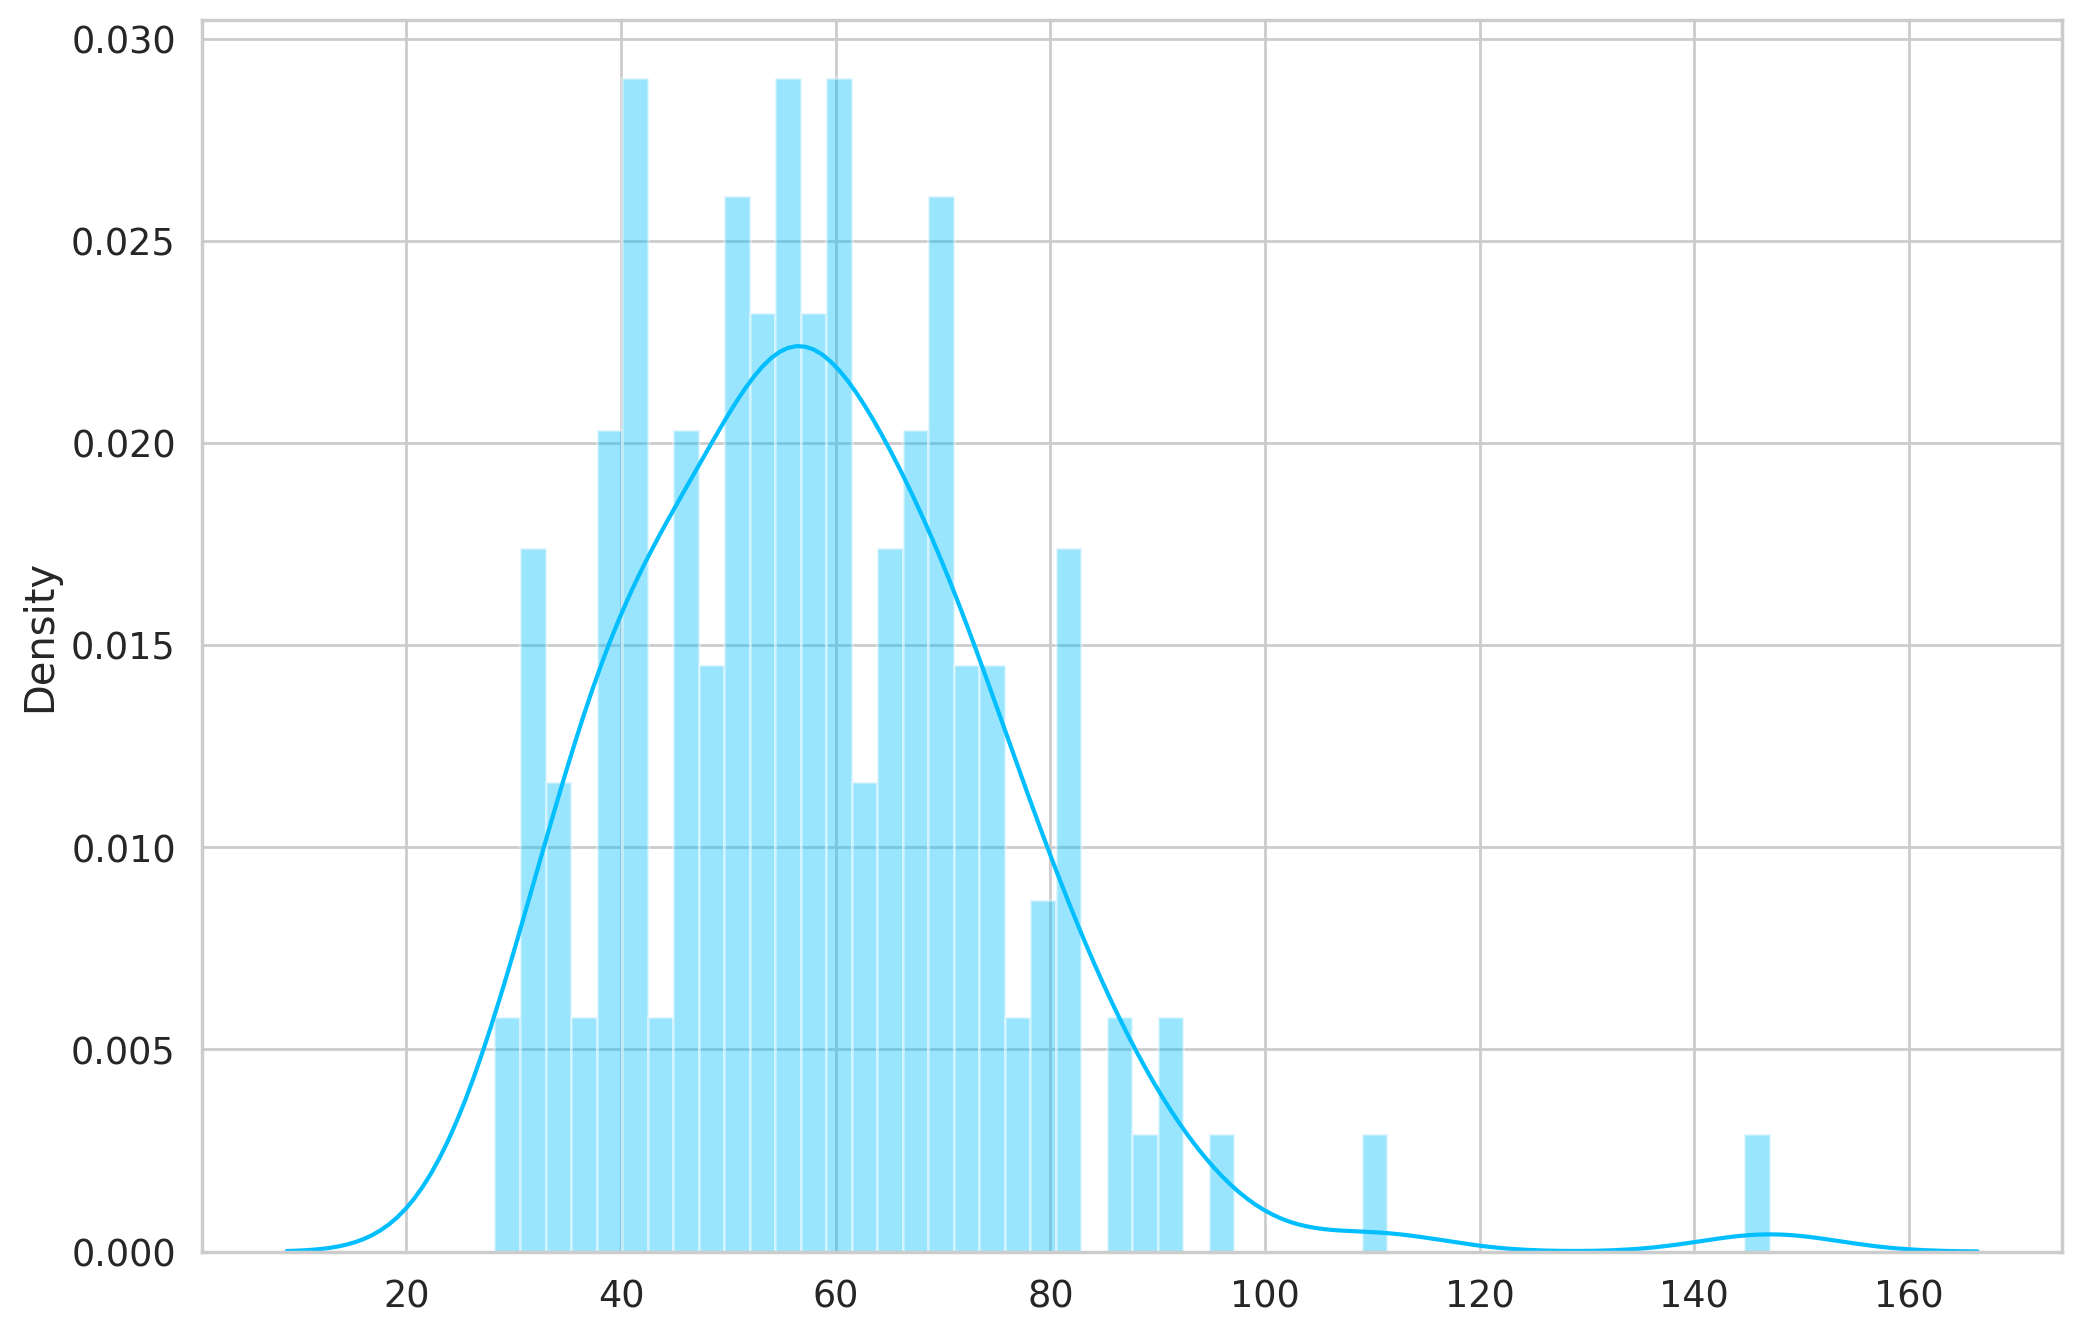

In [61]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True)

In [62]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct Anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct Anomaly predictions: 145/145


In [63]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

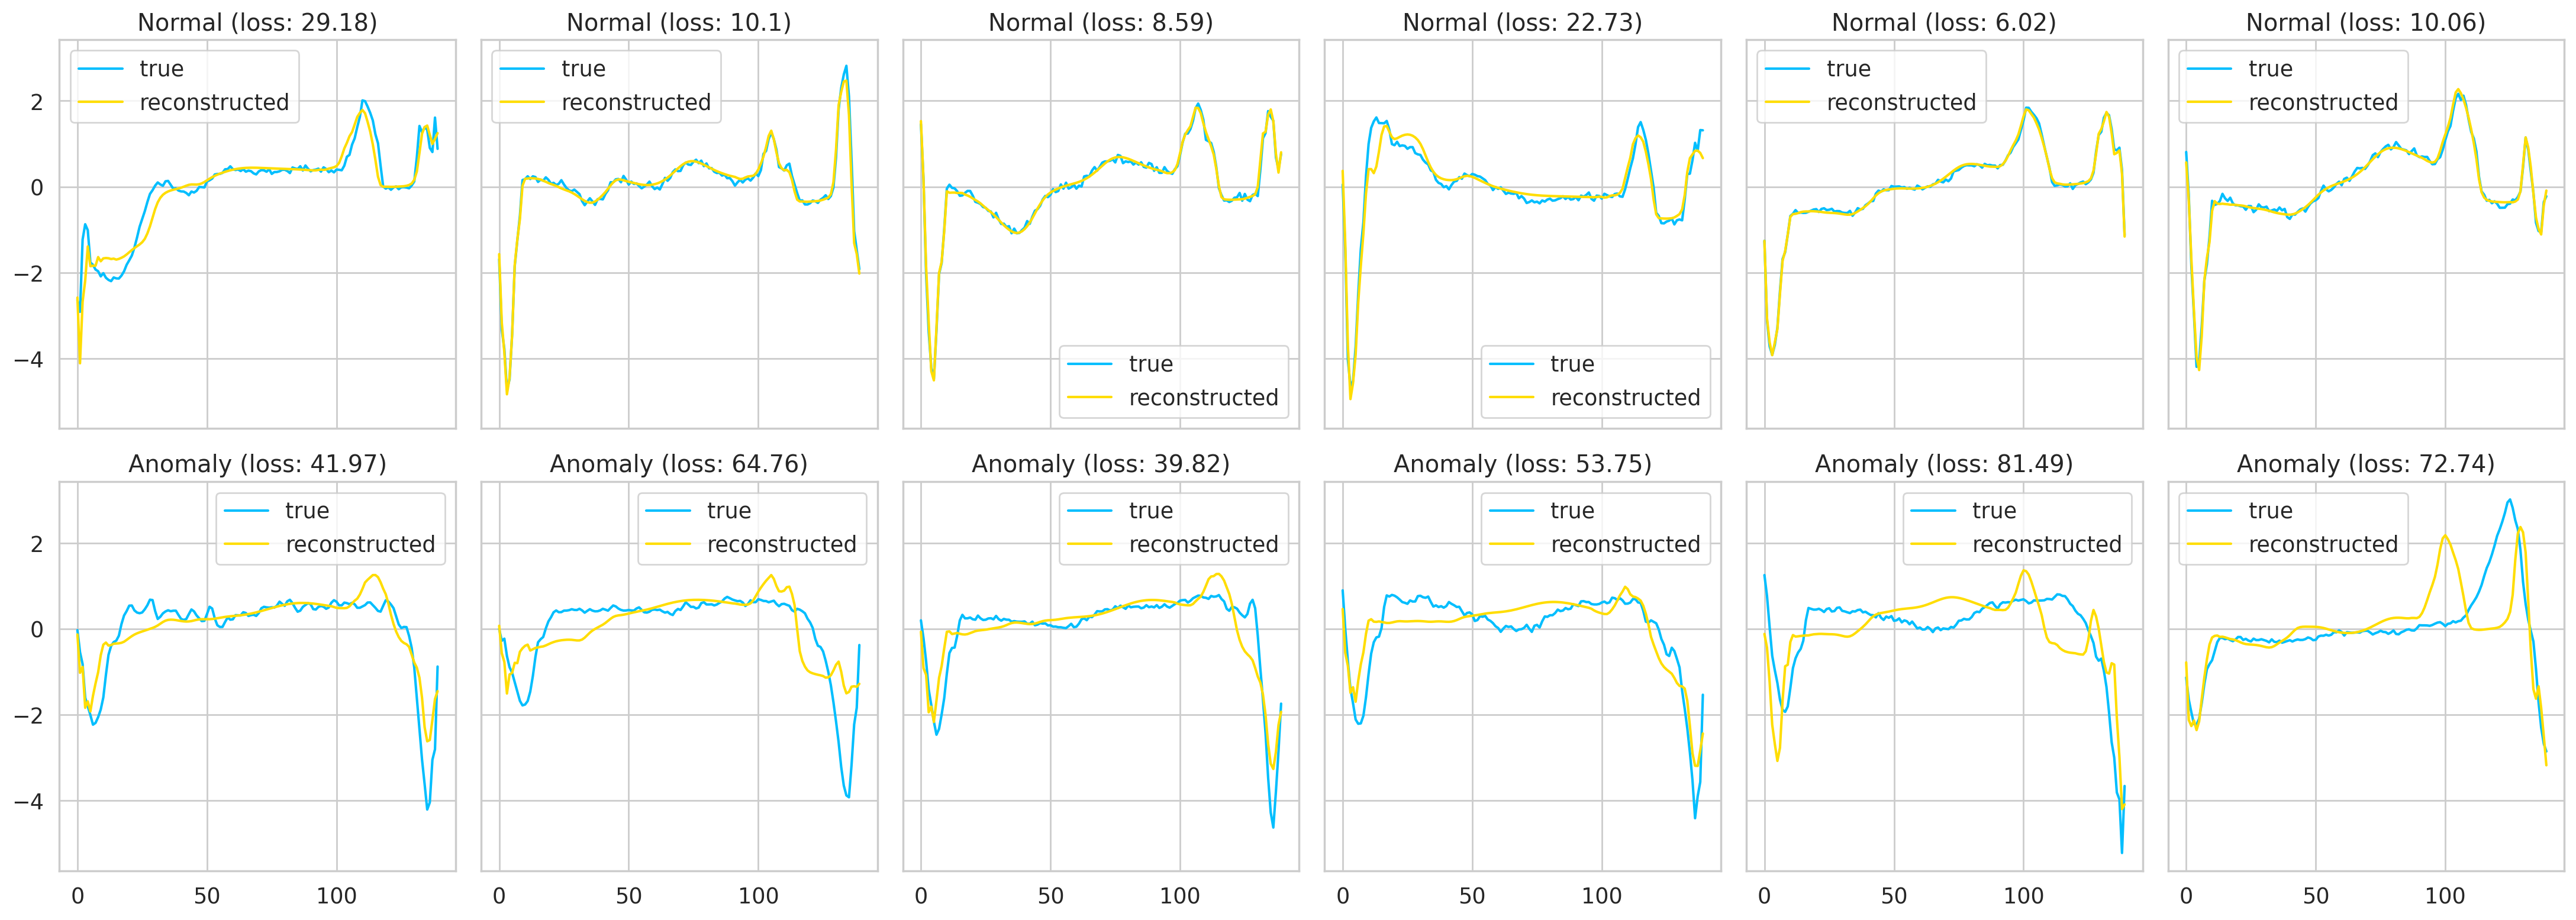

In [64]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()